In [53]:
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
from brainspace.gradient import GradientMaps

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn.connectome import ConnectivityMeasure

In [ ]:
# Restructure Connectome WB label table
labels_gii = nib.load('/scratch/rhaast/hcp_lifespan/resources/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii').get_fdata()
labels_txt = pd.read_csv('/scratch/rhaast/hcp_lifespan/resources/Schaefer2018_1000Parcels_7Networks_order_info.txt',header=None)

df1 = labels_txt[labels_txt.index % 2 != 0].reset_index()
df2 = labels_txt[labels_txt.index % 2 == 0].reset_index()
labels_txt = pd.concat((df1[0].rename('Label'), df2[0].rename('Name')),axis=1) #.columns(['Label','Name'])
labels_txt[['Label','Red','Green','Blue','Alpha']] = labels_txt['Label'].str.split(' ',expand=True)
labels_txt[['Name','Hemisphere','Network','Area','SubArea']] = labels_txt['Name'].str.split('_',expand=True)

In [29]:
dtseries      = nib.load('/scratch/rhaast/test_dimuthu/sub-3118_Month12_clean.dtseries.nii')
dtseries_data = np.transpose(dtseries.get_fdata())[:len(labels_gii[0])]

In [ ]:
# Average across Schaefer parcels
reduced_ts = np.zeros((len(labels_txt),dtseries_data.shape[1]))
for i,label in enumerate(labels_txt.Label):
    mask = (labels_gii==int(label))[0]
    reduced_ts[i,:] = np.nanmean(dtseries_data[mask,:], axis=0)     

In [42]:
reduced_ts = reduced_ts.T
ts = np.where(
    np.isnan(reduced_ts), np.ma.array(reduced_ts, mask=np.isnan(reduced_ts)).mean(axis=0), reduced_ts
) 

In [34]:
correlation_measure = ConnectivityMeasure(kind='correlation')

In [50]:
correlation_matrix = correlation_measure.fit_transform([ts])[0]

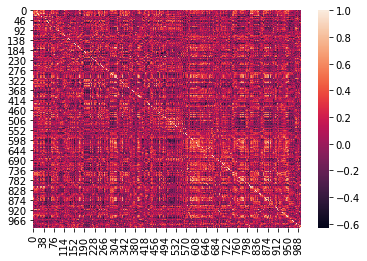

In [51]:
sns.heatmap(correlation_matrix)

In [56]:
# Compute gradients and map to original parcels
ngradients = 10
gm = GradientMaps(n_components=ngradients, kernel='normalized_angle', approach='dm', random_state=0)
gm.fit(correlation_matrix) # i.e., mean correlation matrix

GradientMaps(alignment=None, approach='dm', kernel='normalized_angle',
             n_components=10, random_state=0)

In [ ]:
# Define mask for projecting back to surface
mask = ~np.isin(labels_gii[0],0)

In [63]:
grad = [None] * ngradients
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labels_gii[0], mask=mask, fill=np.nan)

In [ ]:
# Align subject-based gradients to group-based gradients
gp = GradientMaps(n_components=ngradients, kernel='normalized_angle', approach='dm', random_state=0, alignment='procrustes')
    
# With procrustes alignment
nsubjects = len(subjects)
grad_aligned = np.zeros((len(data),ngradients,nsubjects))
for s in range(0,len(subjects)):
    gp.fit(correlation_data[:,:,s], reference=gm.gradients_) # i.e., 3D matrix, with third dimension = subjects
    
    for i, g in enumerate(gp.aligned_.T):
        grad_aligned[:,i,s] = map_to_labels(g, labeling, mask=mask, fill=np.nan)

In [77]:
# To save as gifti file
gii = nib.gifti.GiftiImage()

for g in range(0,len(grad)):
    gii.add_gifti_data_array(
        nib.gifti.GiftiDataArray(data=grad[g][:32492].astype(np.float32)) # For left hemisphere, right hemisphere change to [32492:]
    )
nib.save(gii, '/scratch/rhaast/test_dimuthu/sub-3118_L_gradients.func.gii')

/home/rhaast/venv/neuroimager/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


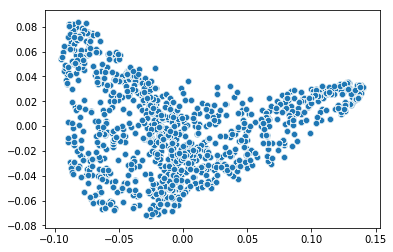

In [80]:
sns.scatterplot(grad[0],grad[2])